In [1]:
%matplotlib notebook

import os
import sys 
import time

import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt


import scipy.optimize as optimize
import scipy.integrate as integrate
import scipy.fftpack as fft
import scipy.interpolate as interp
from scipy import stats
import re
#import spyview_data_import as data_import
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import matplotlib.colors as colors

from collections import OrderedDict
from importlib import reload

e = 1.602176565e-19; #electron charge [C]
k_B = 1.3806488e-23;  #Boltzmann constant [J/K]
hbar = 1.0545718e-34; #reduced Planck constant [Js]
h = 6.626070040e-34 #Planck constant [Js]
G0 = 2*e**2/h #conductance quantum [S]
me = 9.10938215e-31 #electron mass [kg]

In [2]:
from IPython.display import clear_output

import qcodes as qc
from qcodes.dataset.database import initialise_database, get_DB_location
from qcodes import new_experiment, Station, Instrument
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet

In [3]:
qc.config["core"]["db_location"] = r'D:\Data\experiments_2018-10.db'
#qc.config["core"]["db_location"] = r'D:\Data\experiments_201808_and_older.db'
initialise_database()

OperationalError: unable to open database file

In [4]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]  # instead of this, get_DB_location function can be used :)
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "data/junk"
qc.config.save_to_cwd()

In [5]:
from qcodes.dataset.data_export import get_data_by_id

In [16]:
help(get_data_by_id)

Help on function get_data_by_id in module qcodes.dataset.data_export:

get_data_by_id(run_id:int) -> List
    Load data from database and reshapes into 1D arrays with minimal
    name, unit and label metadata.



In [7]:
data2D = get_data_by_id(1027)

In [26]:
data2D[5][2]

{'data': array([ -301.83137278,  -294.01187203,  -317.00404361, ...,   729.27121073,
         1320.8187884 ,   816.25964958]),
 'label': '',
 'name': 'R_xy',
 'unit': 'Ohm'}

In [9]:
B_Xcoord = np.unique(data2D[5][0]['data'])
print('Importing B field values:', data2D[5][0]['name'], 'Units: ', data2D[5][0]['unit'])

TG_Ycoord = np.unique(data2D[5][1]['data'])[::-1]
print('Importing gate values:', data2D[5][1]['name'], 'Units: ', data2D[5][1]['unit'])

get_data_2D_Rxy = np.reshape(np.array(data2D[5][2]['data']), (B_Xcoord.size, TG_Ycoord.size)).T
print('Importing Rxy values:', data2D[5][2]['name'], 'Units: ', data2D[5][2]['unit'])

get_data_2D_Rxx = np.reshape(np.array(data2D[4][2]['data']), (B_Xcoord.size, TG_Ycoord.size)).T
print('Importing Rxx values:', data2D[4][2]['name'], 'Units: ', data2D[4][2]['unit'])

# check if everything's correct
print('Rxy shape:', get_data_2D_Rxy.shape)

Importing B field values: AMI430_x_field Units:  T
Importing gate values: mdac_gate_voltage Units:  V
Importing Rxy values: R_xy Units:  Ohm
Importing Rxx values: R_xx Units:  h/2e^2
Rxy shape: (201, 201)


In [10]:
def doubleYAxisPlot(axLeft, x, yLeft, yRight, xLabel, yLabelLeft, yLabelRight):
    axRight = axLeft.twinx() # this creates another axes object that shares the same x axis and whose y ticks and labels are automatically set to be on the right
    plot_left, = axLeft.plot(x, yLeft, color='#1f77b4') # these are the default colors in matplotlib v2
    plot_right, = axRight.plot(x, yRight, color='#ff7f0e')
    axLeft.set_ylabel(yLabelLeft, color=plot_left.get_color())
    axRight.set_ylabel(yLabelRight, color=plot_right.get_color())
    axLeft.set_xlabel(xLabel)
    # set all tick labels, tick lines and spines to the same color as the plot line
    for t in axLeft.get_yticklabels(): 
        t.set_color(plot_left.get_color())
    for t in axLeft.get_yticklines():
        t.set_color(plot_left.get_color())
    for t in axRight.get_yticklabels():
        t.set_color(plot_right.get_color())
    for t in axRight.get_yticklines():
        t.set_color(plot_right.get_color())
    axLeft.spines['left'].set_color(plot_left.get_color())
    axRight.spines['right'].set_color(plot_right.get_color())
    return (axLeft, axRight)

In [11]:
get_data_2D_Rxx

array([[ 0.3303934 ,  0.31015901,  0.30533604, ...,  0.29656722,
         0.29380651,  0.30346999],
       [ 0.32197055,  0.30299777,  0.30092129, ...,  0.29549343,
         0.29558403,  0.30696558],
       [ 0.31614366,  0.29750584,  0.29869072, ...,  0.30662221,
         0.29772015,  0.29225016],
       ..., 
       [ 4.35557135,  4.61610845,  5.02677391, ...,  4.18586057,
         4.24071353,  4.2763284 ],
       [ 4.40984414,  4.33661325,  4.56285167, ...,  4.29056581,
         4.02776838,  3.81440355],
       [ 4.40883795,  4.44465516,  4.21298484, ...,  3.92723859,
         4.14870811,  3.84523135]])

(201, 201)
(201, 201)


<IPython.core.display.Javascript object>


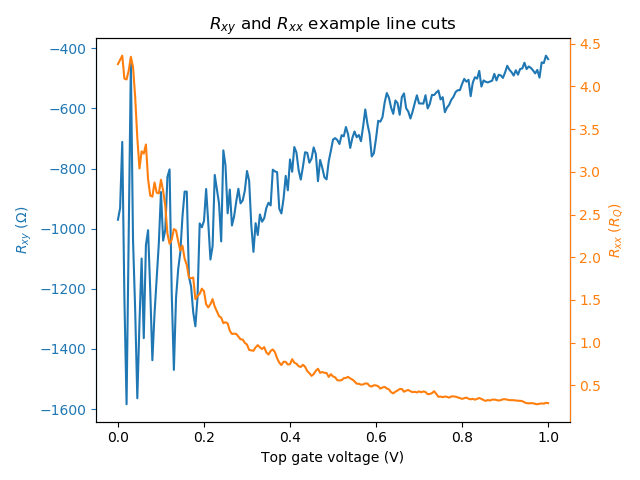

Text(0.5,1,'$R_{xy}$ and $R_{xx}$ example line cuts')

In [15]:
values_Rxy = (get_data_2D_Rxy - np.fliplr(get_data_2D_Rxy))/2 # asymmetrize the transverse voltage
print(values_Rxy.shape)

values_Rxx = (get_data_2D_Rxx + np.fliplr(get_data_2D_Rxx))/2 # symmetrize the longitudinal voltage
print(values_Rxx.shape)

plt.rcParams.update({'figure.autolayout': True}) # make sure enough space is left at the boundaries to display all labels
fig_linecut_check = plt.figure(2)
ax_Rxy = fig_linecut_check.add_subplot(111)
(ax_Rxy, ax_Rxx) = doubleYAxisPlot(axLeft=ax_Rxy, \
                                   x=TG_Ycoord, yLeft=values_Rxy[:,10], yRight=values_Rxx[:,10], \
                                   xLabel='Top gate voltage (V)', \
                                   yLabelLeft='$R_{xy}$ ($\Omega$)',\
                                   yLabelRight='$R_{xx}$ ($R_Q$)')
ax_Rxy.set_title('$R_{xy}$ and $R_{xx}$ example line cuts')

<IPython.core.display.Javascript object>


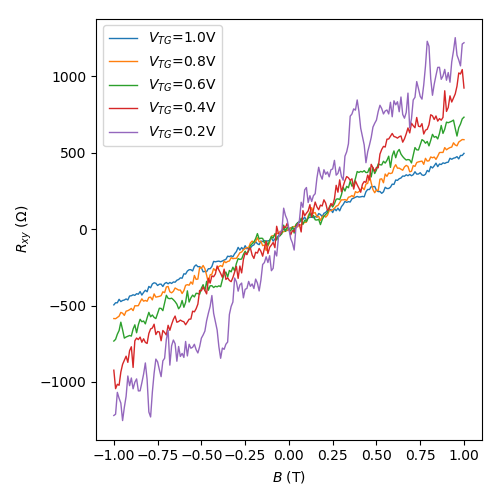

In [16]:
plt.rcParams.update({'figure.autolayout': True}) # make sure enough space is left at the boundaries to display all labels
fig_Rxy_vs_B = plt.figure(num=8, figsize=(5,5))
ax_Rxy_vs_B = fig_Rxy_vs_B.add_subplot(111)
number_of_lines = 5
for i in range(0,number_of_lines):
    ax_Rxy_vs_B.plot(B_Xcoord, values_Rxy[int(i*200/number_of_lines),:], linewidth=1, label='$V_{TG}$='+str(TG_Ycoord[int(i*200/number_of_lines)])+'V')
#ax_Rxy_vs_B.set_ylim([-800,600])
ax_Rxy_vs_B.set_xlabel('$B$ (T)')
ax_Rxy_vs_B.set_ylabel('$R_{xy}$ ($\Omega$)')
ax_Rxy_vs_B.legend()
#fig_Rxy_vs_B.savefig('H6 B linecuts.pdf', format='pdf')

<IPython.core.display.Javascript object>


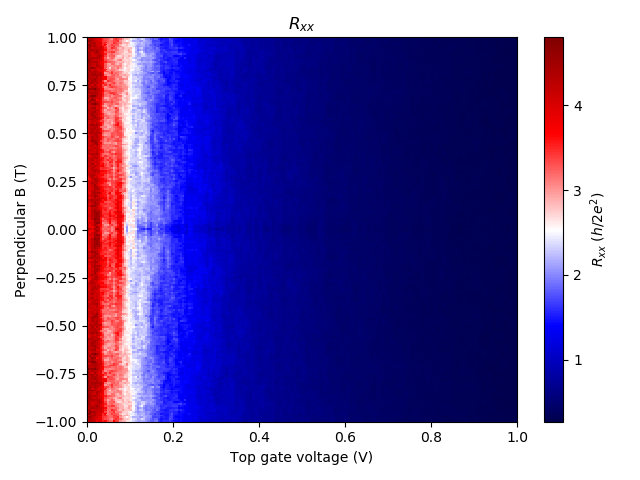

Text(0.5,1,'$R_{xx}$')

In [17]:
# showing a 2D plot of the 2D scan imported above
plt.figure(3)
twoDmap_Rxx = plt.pcolor(TG_Ycoord, B_Xcoord, values_Rxx.transpose(), cmap=cm.get_cmap('seismic'))
#norm=colors.PowerNorm(gamma=0.4, vmin=0, vmax=2.4))
cb=plt.colorbar(twoDmap_Rxx)
cb.set_label('$R_{xx}$ ($h/2e^2$)')
plt.xlim(TG_Ycoord[-1], TG_Ycoord[0])
plt.ylim(B_Xcoord[0], B_Xcoord[-1])
plt.xlabel('Top gate voltage (V)')
plt.ylabel('Perpendicular B (T)')
plt.title('$R_{xx}$')
#plt.savefig('H6 Rxx raw.pdf', format='pdf')

<IPython.core.display.Javascript object>


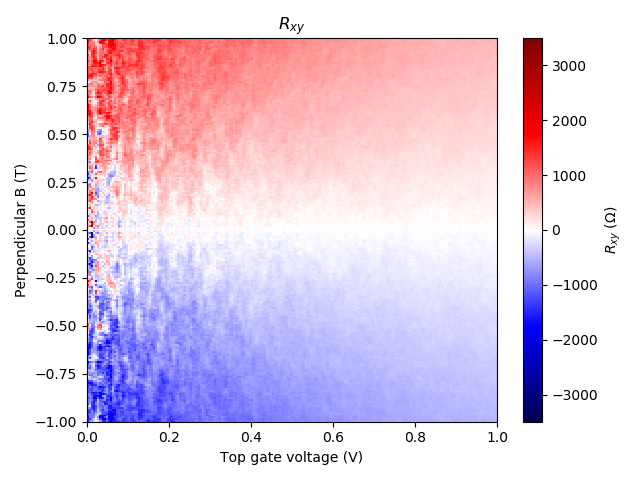

Text(0.5,1,'$R_{xy}$')

In [18]:
# showing a 2D plot of the 2D scan imported above
plt.figure(4)
twoDmap = plt.pcolor(TG_Ycoord, B_Xcoord, values_Rxy.transpose(), cmap=cm.get_cmap('seismic'))
#norm=colors.PowerNorm(gamma=0.4, vmin=0, vmax=2.4))
cb=plt.colorbar(twoDmap)
cb.set_label('$R_{xy}$ ($\Omega$)')
plt.xlim(TG_Ycoord[-1], TG_Ycoord[0])
plt.ylim(B_Xcoord[0], B_Xcoord[-1])
plt.xlabel('Top gate voltage (V)')
plt.ylabel('Perpendicular B (T)')
plt.title('$R_{xy}$')
#plt.savefig('H6 Rxy raw.pdf', format='pdf')

## Some basic Hall effect formulas

Links: [Hall effect](https://en.wikipedia.org/wiki/Hall_effect) and [mobility](https://en.wikipedia.org/wiki/Electron_mobility) Wikipedia pages.

$$ V_H = \frac{I_x B_z}{nte} $$

where $V_H$ is the Hall voltage, $I_x$ the current, $B_z$ perpendicular magnetic field, $n$ carrier density, $t$ thickness (height) of the wire and $e$ the electron charge. In our measurements, $R_{xy} \equiv V_H/I_x$, so fitting $R_{xy}$ and $B_z$ at any given $V_{TG}$ gives the coefficient $1/(nte)$.

From $\sigma = ne\mu$, we have $\mu=\sigma/(ne)$ where $\mu$ is the carrier (electron) mobility and $\sigma$ the conductivity.

To translate this into what we measure directly, 

$$\mu = \sigma t \frac{1}{nte} = \frac{L_{xx}}{R_{xx}W} \frac{1}{nte}$$

$1/(\sigma t)$ is also called the sheet resistance and obtained in our measurements as 

$$\sigma t = \frac{1}{R_{xx}} \frac{L_{xx}}{W}$$

where $R_{xx}$ is the longitudinal resistance via current-bias four-probe measurements, $L_{xx}$ is the distance between two XX leads (`length_xx` defined below) and $W$ the width of the nanowire.

So we first fit the linear coefficient $1/(nte)$ and then directly calculate $n$ and $\mu$ from it.

(201,)


<IPython.core.display.Javascript object>


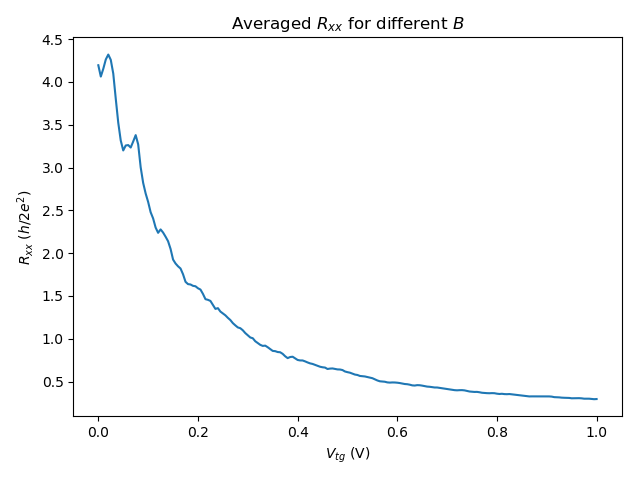

Text(0,0.5,'$R_{xx}$ ($h/2e^2$)')

In [19]:
# Since we are only going to obtain one slope for each V_tg anyway, let's average Rxx over different B's 
Rxx_average_each_gate = values_Rxx.mean(axis=1)
print(Rxx_average_each_gate.shape)
plt.figure(5)
plt.plot(TG_Ycoord, Rxx_average_each_gate)
plt.title('Averaged $R_{xx}$ for different $B$')
plt.xlabel('$V_{tg}$ (V)')
plt.ylabel('$R_{xx}$ ($h/2e^2$)')

In [20]:
# Here begins data processing, finally...

# First, define device geometry
# Length units: m
width_wire = 220e-9
#width_wire = 140e-9*2+100e-9
height_wire = 80e-9 # or "thickness", in usual 2D Hall language
#height_wire = 10e-9 # or "thickness", in usual 2D Hall language
length_SD = 3.3e-6 # length from source to drain
length_xx = 2.23e-6 # length between two xx leads (L1 and L2 in this case)

# calculate (the inverse of) the sheet resistance at each gate value
sigma_t = length_xx / (width_wire * Rxx_average_each_gate*12906.4)

<IPython.core.display.Javascript object>


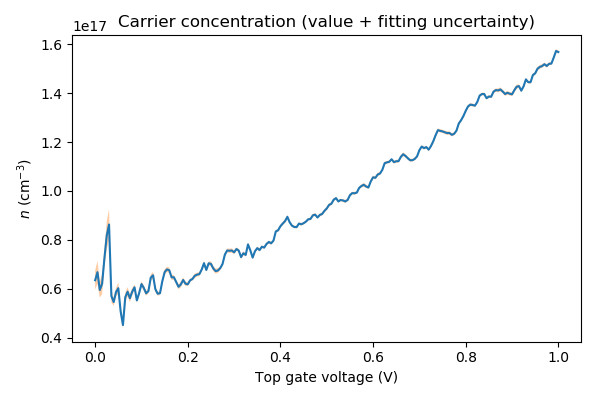

Text(0.5,1,'Carrier concentration (value + fitting uncertainty)')

In [21]:
# fit the coefficient 1/nte

nte_inverse = np.empty_like(TG_Ycoord) # initializing the vector containing the 1/nte coefficients for each TG value
nte_fit_std_err = np.empty_like(TG_Ycoord)
for i in range(0,TG_Ycoord.size):
    nte_inverse[i], intercept, r_value, p_value, nte_fit_std_err[i] = stats.linregress(B_Xcoord,values_Rxy[i,:])

concentration = np.abs(1e-6/(nte_inverse*e*height_wire))
conc_error = nte_fit_std_err * (1e-6/(e*height_wire)) * np.abs(np.power(nte_inverse, -2))
plt.figure(num=6, figsize=(6,4))
plt.plot(TG_Ycoord, concentration) # 1e-6 converts units from m^3 to cm^3
plt.fill_between(TG_Ycoord, concentration-conc_error, concentration+conc_error, alpha=0.5, facecolor='#FF9848')
plt.xlabel('Top gate voltage (V)')
plt.ylabel('$n$ (cm$^{-3}$)')
plt.title('Carrier concentration (value + fitting uncertainty)')
#plt.savefig('H6 concentration.pdf', format='pdf')

<IPython.core.display.Javascript object>


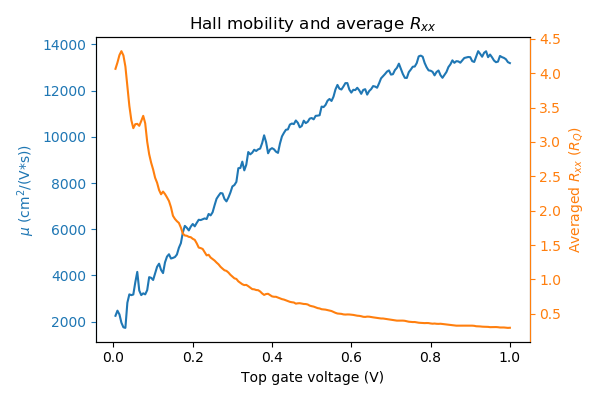

Text(0.5,1,'Hall mobility and average $R_{xx}$')

In [22]:
mu = np.abs(sigma_t * nte_inverse)*1e4

cut_neg_gates = 1 # number of columns of gate values to cut from the plots, 1 = no cutting
plt.rcParams.update({'figure.autolayout': True}) # make sure enough space is left at the boundaries to display all labels
fig_mob = plt.figure(num=7, figsize=(6,4))
ax_mob = fig_mob.add_subplot(111)
(ax_mob, ax_Rxx_average) = doubleYAxisPlot(axLeft=ax_mob, \
                                   x=TG_Ycoord[:-cut_neg_gates], yLeft=mu[:-cut_neg_gates], yRight=Rxx_average_each_gate[:-cut_neg_gates], \
                                   xLabel='Top gate voltage (V)', \
                                   yLabelLeft='$\mu$ (cm$^2$/(V*s))',\
                                   yLabelRight='Averaged $R_{xx}$ ($R_Q$)')
ax_mob.set_title('Hall mobility and average $R_{xx}$')
#fig_mob.savefig('H6 Hall mob.pdf', format='pdf')

<IPython.core.display.Javascript object>


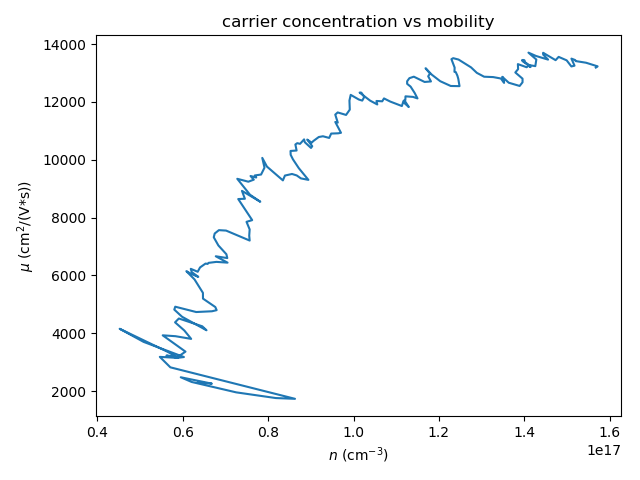

In [23]:
plt.figure(num=9)
plt.plot(concentration, mu) # 1e-6 converts units from m^3 to cm^3
plt.xlabel('$n$ (cm$^{-3}$)')
plt.ylabel('$\mu$ (cm$^2$/(V*s))')
plt.title('carrier concentration vs mobility')
plt.savefig('Q169 H1 n vs mu.pdf', format='pdf')

<IPython.core.display.Javascript object>


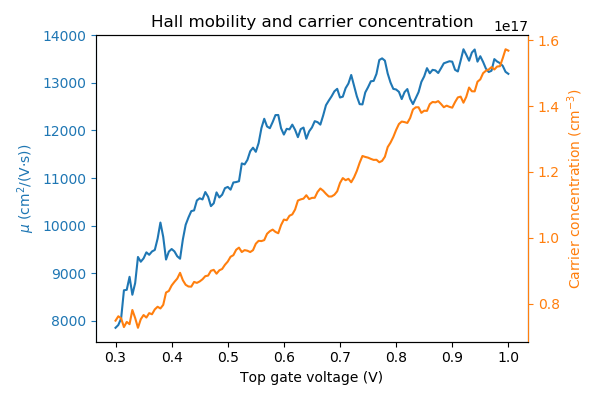

In [24]:
cut_neg_gates = 60 # number of columns of gate values to cut from the plots, 1 = no cutting
plt.rcParams.update({'figure.autolayout': True}) # make sure enough space is left at the boundaries to display all labels
fig_mob_conc = plt.figure(num=10, figsize=(6,4))
ax_mob_left = fig_mob_conc.add_subplot(111)
(ax_mob_left, ax_conc_right) = doubleYAxisPlot(axLeft=ax_mob_left, \
                                   x=TG_Ycoord[:-cut_neg_gates], yLeft=mu[:-cut_neg_gates], yRight=concentration[:-cut_neg_gates], \
                                   xLabel='Top gate voltage (V)', \
                                   yLabelLeft='$\mu$ (cm$^2$/(V$\cdot$s))',\
                                   yLabelRight='Carrier concentration (cm$^{-3}$)')
ax_mob_left.set_title('Hall mobility and carrier concentration')
fig_mob_conc.savefig('Q169 n and mu.pdf', format='pdf')